# Using PyMC3 to fit Gaussian curves to photopeaks in a gamma-ray spectrum

A gamma-ray spectrum (GRS) is a histogram describing the counts of detected photons as a function of photon energy. GRS can be useful when evaluating the dosage received from a sample containing unknown radioisotopes. To do this, the GRS has to be integrated with respect to photon energy to find the total counts, which can only be done by fitting curves to the GRS. In this example, I'll use MCMC to fit Gaussian curves to peaks found in a GRS of a sample of Ba-133.

### Useful imports:

In [1]:
import numpy as np

from scipy.signal import find_peaks
from scipy.stats import gaussian_kde

import corner

from time import time

import matplotlib.pyplot as plt
%matplotlib inline

import pymc3 as pm
print('PyMC3 version: {}'.format(pm.__version__))

PyMC3 version: 3.8


### Viewing the data:

First, load calibration parameters (specific to the detector), and load the gamma-ray spectrum.

In [2]:
#Load detector calibration
cali_dir = "calibration.txt"
with open(cali_dir, "r") as file:
    calibration = file.read().splitlines()
calibration = list(map(float, calibration))
c_0 = calibration[0]
c_2 = calibration[2]

#Load gamma-ray spectrum data
spectra_dir = "Ba.TKA"
with open(spectra_dir, "r") as file:
    counts = [int(j) for j in file]
counts = counts[2:]

Next, plot the spectrum between 540 and 3500 MCA Channels (outside this range, the spectrum is very noisy and not very useful).

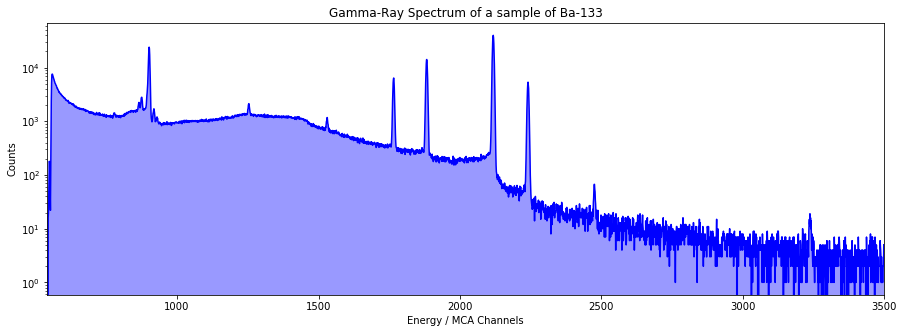

In [3]:
xrange = np.array(range(len(counts)))  # Bins for gamma-ray spectrum

# Plot the spectrum
plt.figure(figsize=(15,5))
plt.plot(xrange, counts, "b")
plt.fill(xrange, counts, "b", alpha= 0.4)
plt.xlabel("Energy / MCA Channels")
plt.ylabel("Counts")
plt.title("Gamma-Ray Spectrum of a sample of Ba-133")
plt.yscale("log")
plt.xlim(540, 3500)
plt.show()

The spectrum is made up of a smooth background counts curve, with sharp peaks sitting on top. These peaks are called photopeaks, and are caused by discrete energy level changes in the nucleus of Ba-133 when it decays. Using scipy, we can select some large peaks in the spectrum to analyse.

In [4]:
# Find prominent peaks in data using scipy
peaks = find_peaks(counts, height=1300, distance=100)[0][3:]

Next, create some plots to see which peaks we found, and calibrate from MCA Channels to keV:

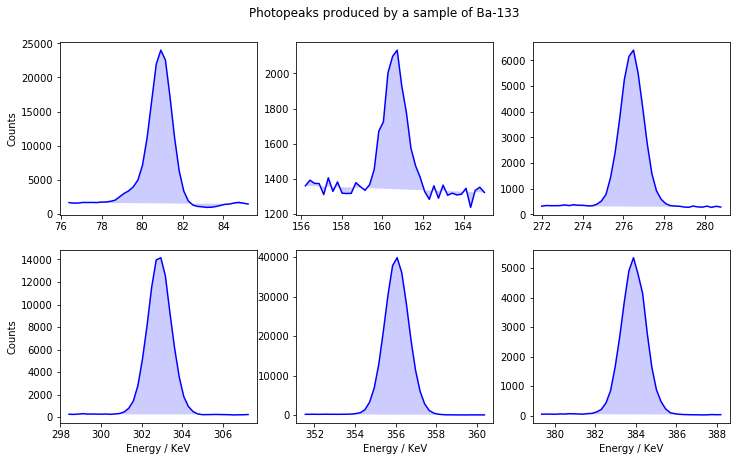

In [5]:
# select an area around peak to be plotted & calibrate energy scale to keV 
ranger = 20
peaks_x = [c_0*np.array(range(peak-ranger, peak+ranger)) + c_2 for peak in peaks]
peaks_y = [counts[peak-ranger:peak+ranger] for peak in peaks]

# Plot selected peaks from gamma-ray spectrum
fig, axs = plt.subplots(2,3, figsize=(12,7))
for i in range(2):
    for j in range(3):
        ind = 3*i + j
        axs[i,j].plot(peaks_x[ind], peaks_y[ind], "b")
        axs[i, j].fill(peaks_x[ind], peaks_y[ind], "b", alpha=0.2)
        if i == 1:
            axs[i,j].set_xlabel("Energy / KeV")
        if j == 0:
            axs[i,j].set_ylabel("Counts")
fig.suptitle("Photopeaks produced by a sample of Ba-133", y=0.95)
plt.show()

### Sampling the data:

These 6 peaks appear Gaussian in nature, so we'll attempt to fit Gaussian curves. To do this, start by defining a Gaussian function:

In [6]:
def gauss(x, a, xc, w, y0):
    """
    Gaussian function
    :param x: Array of input points
    :param a: Amplitude of peak
    :param xc: Mean peak energy
    :param w: Standard deviation of peak
    :param y0: Background counts under peak
    :return:
    """
    return a*np.exp(-(x-xc)**2/(2*abs(w)**2))+y0

Out goal is to find the values of the parameters above that best explain each photopeak. To ensure that the algorithms converge, guess some values for the parameters of each peak. Since the standard deviation appears roughly the same for all the peaks, I won't use an individual guess for each peak.

In [7]:
#initialise a model for each peak, and define guesses for the parameters
gauss_models = [pm.Model() for i in range(len(peaks))]
a_guesses = [23000., 900., 6100., 13800., 39800., 5300.]
xc_guesses = [81., 161., 276.5, 303., 356., 384.]
y0_guesses = [1700., 1350., 300., 300., 250., 50.]

Next, create the models for each photopeak by setting the priors for the parameters, defining an expected outcome, and defining a likelihood function. 

In [8]:
for j in range(len(peaks)):
    with gauss_models[j]:
        # set prior parameters
        # amplitude
        a_mu = a_guesses[j]    # mean of amplitude of peaks
        a_sig = 100.            # standard deviation of amplitude of peaks

        # peak energy
        xc_mu = xc_guesses[j]  # mean of peak energy
        xc_sig = 1.            # standard deviation of peak energy

        # standard deviation
        w_mu = 1.2             # mean of peak standard deviation
        w_sig = 1.             # standard deviation of peak standard deviation

        # background counts
        y0_mu = y0_guesses[j]  # mean of background counts
        y0_sig = 30.           # standard deviation of background counts

        # set normal priors
        a_model = pm.Normal('Amplitude', mu=a_mu, sd=a_sig) 
        xc_model = pm.Normal('Peak Energy', mu=xc_mu, sd=xc_sig)  
        w_model = pm.Normal('Standard Deviation', mu=w_mu, sd=w_sig)  
        y0_model = pm.Normal('Background Counts', mu=y0_mu, sd=y0_sig)
        
        # Expected value of outcome
        mu = gauss(peaks_x[j], a_model, xc_model, w_model, y0_model)

        # Gaussian likelihood of observations
        Y_obs = pm.Poisson('Y_obs', mu=mu, observed=peaks_y[j])

Now that the models have been created, run the sampling algorithms on each peak:

In [9]:
Nsamples = 800 # number of samples
Ntune = 1000    # number of tuning samples

# perform sampling
traces = []
t0 = time()
for i in range(len(peaks)):
    with gauss_models[i]:
        traces.append(pm.sample(Nsamples, tune=Ntune, discard_tuned_samples=True)) # perform sampling
t1 = time()

timepymc3 = (t1-t0)  # time taken to sample all of the photopeaks

print("{} seconds taken to run PyMC3 sampling.".format(timepymc3))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Background Counts, Standard Deviation, Peak Energy, Amplitude]
Sampling 4 chains, 0 divergences: 100%|██████████| 7200/7200 [00:06<00:00, 1068.10draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Background Counts, Standard Deviation, Peak Energy, Amplitude]
Sampling 4 chains, 0 divergences: 100%|██████████| 7200/7200 [00:05<00:00, 1376.94draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Background Counts, Standard Deviation, Peak Energy, Amplitude]
Sampling 4 chains, 0 divergences: 100%|██████████| 7200/7200 [00:06<00:00, 1094.72draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Background Counts, Standard Deviat

115.38531970977783 seconds taken to run PyMC3 sampling.


### Results:

Now that the data has been sampled, we can collect the information for each parameter posterior using the traces:

In [10]:
# collect traces of each parameter from each peak
all_pymc3_samples = [np.vstack((trace['Amplitude'],
                                trace['Peak Energy'],
                                trace['Standard Deviation'],
                                trace['Background Counts'])).T for trace in traces]

# dictionaries to contain mean and standard deviation of each peak
resdict = [{} for i in range(len(peaks))]
for ind in range(len(peaks)):
    resdict[ind]['a_mu'] = np.mean(all_pymc3_samples[ind][:, 0])
    resdict[ind]['a_sig'] = np.std(all_pymc3_samples[ind][:, 0])
    resdict[ind]['xc_mu'] = np.mean(all_pymc3_samples[ind][:, 1])
    resdict[ind]['xc_sig'] = np.std(all_pymc3_samples[ind][:, 1])
    resdict[ind]['w_mu'] = np.mean(all_pymc3_samples[ind][:, 2])
    resdict[ind]['w_sig'] = np.std(all_pymc3_samples[ind][:, 2])
    resdict[ind]['y0_mu'] = np.mean(all_pymc3_samples[ind][:, 3])
    resdict[ind]['y0_sig'] = np.std(all_pymc3_samples[ind][:, 3])

To visualise the information given for each parameter, we can define a function to plot the parameter posteriors, and also create contour plots that describe how any two parameters might depend on each other. I used the 2nd photopeak for this, as it has the noisest original data, and so it may show more interesting results: 

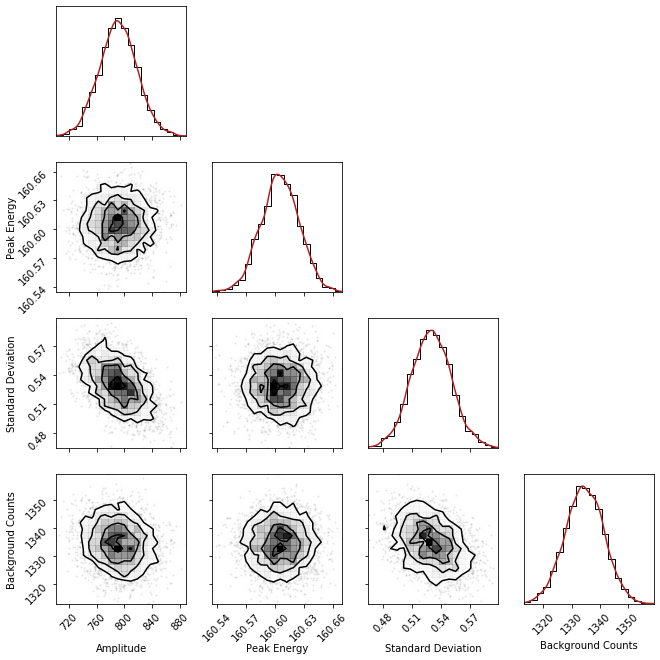

<Figure size 504x504 with 0 Axes>

In [11]:
def plotposts(samples, labels, **kwargs):
    """
    Function to plot posteriors using corner.py and scipy's gaussian KDE function.
    """

    fig = corner.corner(samples, labels=labels, hist_kwargs={'density': True}, **kwargs)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.figure(figsize=(7, 7))
    # plot KDE smoothed version of distributions
    for axidx, samps in zip([0, 5, 10, 15], samples.T):
        kde = gaussian_kde(samps)
        xvals = fig.axes[axidx].get_xlim()
        xvals = np.linspace(xvals[0], xvals[1], 100)
        fig.axes[axidx].plot(xvals, kde(xvals), color='firebrick')

# create corner plot for peak with noisiest data 
labels = [r"Amplitude", r"Peak Energy", r"Standard Deviation", r"Background Counts"]
corner_plot_samples = all_pymc3_samples[1]

plotposts(corner_plot_samples, labels)

We can view the mean value and standard deviation error of each parameter:

In [12]:
a, a_err = resdict[1]["a_mu"], resdict[1]["a_sig"]
xc, xc_err = resdict[1]["xc_mu"], resdict[1]["xc_sig"]
w, w_err = resdict[1]["w_mu"], resdict[1]["w_sig"]
y0, y0_err = resdict[1]["y0_mu"], resdict[1]["y0_sig"]

print("         Amplitude = {} \u00B1 {} \n".format(a, a_err) +
      "       Peak Energy = {} \u00B1 {} \n".format(xc, xc_err) +
      "Standard Deviation = {} \u00B1 {} \n".format(w, w_err) +
      " Background Counts = {} \u00B1 {} \n".format(y0, y0_err))

         Amplitude = 791.0381524977175 ± 27.062277830578772 
       Peak Energy = 160.6053614221172 ± 0.01985063881589611 
Standard Deviation = 0.5299054366212894 ± 0.020468563717501696 
 Background Counts = 1334.5688875454935 ± 6.803671065848645 



In [13]:
# number of curves to plot per peak
n_fits = 100
a_samps, xc_samps, w_samps, y0_samps = ([] for i in range(4))
for ind in range(len(peaks)):
    a_samps.append(np.random.choice(all_pymc3_samples[ind][:, 0], size=n_fits))
    xc_samps.append(np.random.choice(all_pymc3_samples[ind][:, 1], size=n_fits))
    w_samps.append(np.random.choice(all_pymc3_samples[ind][:, 2], size=n_fits))
    y0_samps.append(np.random.choice(all_pymc3_samples[ind][:, 3], size=n_fits))

Finally, we can plot the photopeaks, with the Gaussian curves superimposed onto each plot.

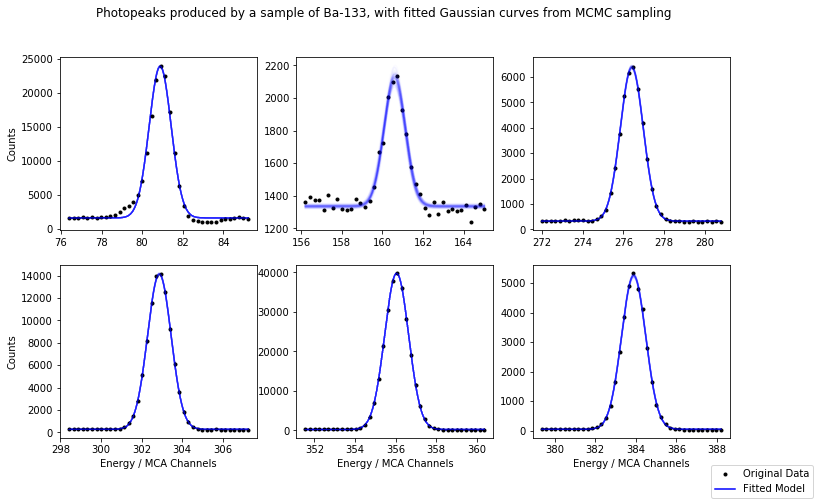

In [14]:
# plot each peak, with the fitted Gaussians superimposed
fig, axs = plt.subplots(2, 3, figsize=(12, 7))
for i in range(2):
    for j in range(3):
        ind = 3 * i + j
        
        a = resdict[ind]["a_mu"]
        xc = resdict[ind]["xc_mu"]
        wr = resdict[ind]["w_mu"]
        y0 = resdict[ind]["y0_mu"]
        
        x = peaks_x[ind]
        y = peaks_y[ind]
        
        xsmooth = np.linspace(x[0], x[-1], len(x) * 100)
        # plot original data
        axs[i, j].plot(x, y, "k.", alpha=1, label=("Original Data" if all(num == 0 for num in [i,j]) else ""))
        
        # plot a fit for each randomly drawn parameter value
        for k in range(n_fits):
            axs[i, j].plot(xsmooth, 
                           gauss(xsmooth, a_samps[ind][k], xc_samps[ind][k], w_samps[ind][k], y0_samps[ind][k]), "b-",
                           label=("Fitted Model" if all(num == 0 for num in [i,j,k]) else ""),
                           alpha=0.015)

        if i == 1:
            axs[i, j].set_xlabel("Energy / MCA Channels")
        if j == 0:
            axs[i, j].set_ylabel("Counts")
leg = fig.legend(loc="lower right", numpoints=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
fig.suptitle("Photopeaks produced by a sample of Ba-133, with fitted Gaussian curves from MCMC sampling")
plt.show()